<a href="https://colab.research.google.com/github/RenChina/FinPortfolio/blob/master/04_hw_clustering%D0%91%D0%B0%D0%B1%D0%B5%D0%BD%D0%BA%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm

%matplotlib inline

np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
anime = pd.read_csv('/content/anime.csv', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
ratings = pd.read_csv('/content/anime.csv')
ratings.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет.

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут.

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее.

### 1. Избавьтесь от -1

In [6]:
ratings = ratings[ratings['rating'] != -1]

## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ \operatorname{erfc}(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

`erfc` — это дополнительная функция ошибок Гаусса. [wiki](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA)

$$\operatorname{erfc}\,x = 1-\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}} \int\limits_x^{\infty} e^{-t^2}\,\mathrm dt$$

$$\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}}\int\limits_0^x e^{-t^2}\,\mathrm dt$$

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn.

In [15]:
from scipy.special import erfc

def chauvenet(array):
    mean = np.mean(array)
    std = np.std(array)
    N = len(array)
    criterion = 1 / (2 * N)
    mask = erfc(np.abs(array - mean) / (std * np.sqrt(2))) > criterion
    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [12]:
ratings = pd.read_csv('/content/rating.csv')

ratings = ratings[ratings['rating'] != -1]
count_reviews = ratings.groupby('user_id').count()['rating']
count_reviews

,rating
user_id,
1,4
2,1
3,92
5,459
7,343
...,...
73512,12
73513,33
73514,1


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [17]:
outlier_users = count_reviews[~chauvenet(count_reviews.values)]
outlier_users

,rating
user_id,
226,742
446,743
478,863
958,783
1145,904
...,...
70953,830
71792,1014
73135,986


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**

Критерий Шавене посчитал выбросами пользователей, которые имеют аномальное количество просмотренных аниме, значительно отличающееся от среднего значения.  Эти пользователи указаны в переменной `outlier_users`


Критерий Шавене определяет выбросы как точки данных, вероятность появления которых при заданном распределении очень мала.  В данном случае, пользователи с аномально большим или малым количеством просмотров аниме были идентифицированы как выбросы, так как их значения лежат далеко от среднего количества просмотров, выходя за пределы допустимого отклонения

Возможно, да.  Пользователи с большим количеством просмотров могут быть заинтересованы в более специфических рекомендациях, учитывающих их широкий спектр предпочтений.  Пользователям с малым количеством просмотров может потребоваться более общая рекомендательная система, которая поможет им найти новые интересные аниме.  Необходимость в системе зависит от их индивидуальных предпочтений и целей использовани

In [18]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

701

Если все было правильно `bad_user_threshold` больше 500.

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [27]:
count_reviews = count_reviews.rename_axis('user_id').rename('review_count')

ratings = ratings.merge(count_reviews, left_on='user_id', right_index=True)

ratings = ratings[ratings['review_count'] < bad_user_threshold]
ratings

,user_id,anime_id,rating,count_reviews_x,count_reviews_y,count_reviews,review_count_x,review_count_y,review_count
0,1,8074,10,4,4,4,4,4,4
1,1,11617,10,4,4,4,4,4,4
2,1,11757,10,4,4,4,4,4,4
3,1,15451,10,4,4,4,4,4,4
4,2,11771,10,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
5804465,73515,16512,7,179,179,179,179,179,179
5804466,73515,17187,9,179,179,179,179,179,179
5804467,73515,22145,10,179,179,179,179,179,179
5804468,73516,790,9,2,2,2,2,2,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [28]:
median_reviews = ratings['review_count'].median()
ratings = ratings[ratings['review_count'] >= median_reviews]
ratings

,user_id,anime_id,rating,count_reviews_x,count_reviews_y,count_reviews,review_count_x,review_count_y,review_count
97,5,6,8,459,459,459,459,459,459
98,5,15,6,459,459,459,459,459,459
99,5,17,6,459,459,459,459,459,459
100,5,18,6,459,459,459,459,459,459
101,5,20,6,459,459,459,459,459,459
...,...,...,...,...,...,...,...,...,...
5804082,73507,8231,5,259,259,259,259,259,259
5804083,73507,8348,5,259,259,259,259,259,259
5804084,73507,8440,7,259,259,259,259,259,259
5804085,73507,8769,8,259,259,259,259,259,259


In [40]:
# Удалили count_reviews
ratings

,user_id,anime_id,rating,count_reviews_x,count_reviews_y,review_count_x,review_count_y,review_count
97,5,6,8,459,459,459,459,459
98,5,15,6,459,459,459,459,459
99,5,17,6,459,459,459,459,459
100,5,18,6,459,459,459,459,459
101,5,20,6,459,459,459,459,459
...,...,...,...,...,...,...,...,...
5804082,73507,8231,5,259,259,259,259,259
5804083,73507,8348,5,259,259,259,259,259
5804084,73507,8440,7,259,259,259,259,259
5804085,73507,8769,8,259,259,259,259,259


Теперь рассмотрим таблицу `anime`.


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [42]:
rating_mask = chauvenet(anime['rating'].values)
members_mask = chauvenet(anime['members'].values)

combined_mask = rating_mask & members_mask

outlier_indices = anime.index[~combined_mask]

anime = anime.drop(outlier_indices)
outlier_anime = anime
outlier_anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе?

**Ответы:**
Критерий посчитал выбросами аниме с аномальными рейтингами и/или количеством участников

Аномальные значения рейтингов и количества участников лежат далеко от среднего значения, выходя за пределы допустимого отклонения, согласно критерию Шавене

Да, можно использовать эти аниме, например, для формирования отдельных рекомендаций для пользователей с нестандартными предпочтениями, или для анализа аномалий в данных


## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы.

In [43]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [44]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Comedy, Drama, School, Shounen, Sports' 'Drama, Military, Sci-Fi, Space'
 'Drama, School, Shounen'
 'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural'
 'Action, Drama, Historical, Martial Arts, Romance, Samurai'
 'Drama, Fantasy, Shoujo, Slice of Life, Supernatural'
 'Comedy, Drama, Shounen, Sports' 'Action, Mystery, Supernatural, Vampire'
 'Comedy, Drama, Romance, Shounen']
len= 3112

Genres=['Harem', 'Demons', 'Martial Arts', 'Samurai', 'Parody', 'Super Power', 'Seinen', 'Cars', 'Dementia', 'Historical', 'Hentai', 'Shounen Ai', 'Adventure', 'School', 'Ecchi', 'Horror', 'Game', 'Sci-Fi', 'Comedy', 'Sports', 'Yuri', 'Mystery', 'Magic', 'Yaoi', 'Military', 'Vampire', 'Mecha', 'Fantasy', 'Shoujo', 'Music', 'Josei', 'Slice of Life', 'Psychological', 'Space', 'Romance', 'Shoujo Ai', 'Shounen', 'Kids', 'Thriller', 'Action', 'Supernatural', 'Police', 'Drama']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [45]:
one_hot_genres = pd.DataFrame(0, index=anime.index, columns=genres)

for anime_id, row in anime.iterrows():
    for genre in genre_splitter(row['genre']):
        if genre in one_hot_genres.columns:
            one_hot_genres.loc[anime_id, genre] = 1

one_hot_genres

,Harem,Demons,Martial Arts,Samurai,Parody,Super Power,Seinen,Cars,Dementia,Historical,...,Space,Romance,Shoujo Ai,Shounen,Kids,Thriller,Action,Supernatural,Police,Drama
anime_id,,,,,,,,,,,,,,,,,,,,,
28977,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
32935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
820,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
15335,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
15417,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [48]:
df = ratings.merge(one_hot_genres, left_on='anime_id', right_index=True)
df

,user_id,anime_id,rating,count_reviews_x,count_reviews_y,review_count_x,review_count_y,review_count,Harem,Demons,...,Space,Romance,Shoujo Ai,Shounen,Kids,Thriller,Action,Supernatural,Police,Drama
98,5,15,6,459,459,459,459,459,0,0,...,0,0,0,1,0,0,1,0,0,0
99,5,17,6,459,459,459,459,459,0,0,...,0,0,0,1,0,0,0,0,0,0
100,5,18,6,459,459,459,459,459,0,0,...,0,0,0,0,0,0,1,0,0,1
102,5,22,5,459,459,459,459,459,0,0,...,0,0,0,1,0,0,1,0,0,0
108,5,63,1,459,459,459,459,459,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5804081,73507,8211,5,259,259,259,259,259,0,0,...,0,0,0,0,0,0,1,1,0,0
5804082,73507,8231,5,259,259,259,259,259,0,0,...,0,0,0,0,0,0,0,0,0,0
5804083,73507,8348,5,259,259,259,259,259,0,0,...,0,0,0,0,0,0,0,0,0,0
5804084,73507,8440,7,259,259,259,259,259,0,0,...,0,0,0,0,0,0,0,0,0,0


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [57]:
for genre in genres:
    df[genre] = df[genre].replace(0, np.nan)

user_genre_ratings = df.groupby('user_id')[genres].mean()

user_genre_ratings = user_genre_ratings.fillna(-1)

df.head()

,Harem,Demons,Martial Arts,Samurai,Parody,Super Power,Seinen,Cars,Dementia,Historical,...,Space,Romance,Shoujo Ai,Shounen,Kids,Thriller,Action,Supernatural,Police,Drama
user_id,,,,,,,,,,,,,,,,,,,,,
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0


from matplotlib import pyplot as plt
_df_0['Martial Arts'].plot(kind='hist', bins=20, title='Martial Arts')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Cars'].plot(kind='hist', bins=20, title='Cars')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Dementia'].plot(kind='hist', bins=20, title='Dementia')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Shounen Ai'].plot(kind='hist', bins=20, title='Shounen Ai')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Martial Arts', y='Cars', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Cars', y='Dementia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Dementia', y='Shounen Ai', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Shounen Ai', y='Military', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Harem']
  ys = series['Martial Arts']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Harem', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Harem')
_ = plt.ylabel('Martial Arts')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Harem']
  ys = series['Cars']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Harem', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Harem')
_ = plt.ylabel('Cars')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Harem']
  ys = series['Dementia']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Harem', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Harem')
_ = plt.ylabel('Dementia')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Harem']
  ys = series['Military']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Harem', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Harem')
_ = plt.ylabel('Military')

from matplotlib import pyplot as plt
_df_12['Martial Arts'].plot(kind='line', figsize=(8, 4), title='Martial Arts')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Cars'].plot(kind='line', figsize=(8, 4), title='Cars')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Dementia'].plot(kind='line', figsize=(8, 4), title='Dementia')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Shounen Ai'].plot(kind='line', figsize=(8, 4), title='Shounen Ai')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['user_id'].plot(kind='hist', bins=20, title='user_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Martial Arts'].plot(kind='hist', bins=20, title='Martial Arts')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['Cars'].plot(kind='hist', bins=20, title='Cars')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['Dementia'].plot(kind='hist', bins=20, title='Dementia')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='user_id', y='Martial Arts', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='Martial Arts', y='Cars', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='Cars', y='Dementia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='Dementia', y='Shounen Ai', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_id']
  ys = series['Martial Arts']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('user_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_id')
_ = plt.ylabel('Martial Arts')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_id']
  ys = series['Cars']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('user_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_id')
_ = plt.ylabel('Cars')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_id']
  ys = series['Dementia']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('user_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_id')
_ = plt.ylabel('Dementia')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user_id'}, axis=1)
              .sort_values('user_id', ascending=True))
  xs = counted['user_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('user_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_28['user_id'].plot(kind='line', figsize=(8, 4), title='user_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['Martial Arts'].plot(kind='line', figsize=(8, 4), title='Martial Arts')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['Cars'].plot(kind='line', figsize=(8, 4), title='Cars')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['Dementia'].plot(kind='line', figsize=(8, 4), title='Dementia')
plt.gca().spines[['top', 'right']].set_visible(False)

Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [59]:
user_genre_ratings = user_genre_ratings.fillna(-1)
df.head()

,Harem,Demons,Martial Arts,Samurai,Parody,Super Power,Seinen,Cars,Dementia,Historical,...,Space,Romance,Shoujo Ai,Shounen,Kids,Thriller,Action,Supernatural,Police,Drama
user_id,,,,,,,,,,,,,,,,,,,,,
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [60]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(user_genre_ratings)
user_genre_ratings_scaled = pd.DataFrame(scaled_features, index=user_genre_ratings.index, columns=user_genre_ratings.columns)
user_genre_ratings_scaled


,Harem,Demons,Martial Arts,Samurai,Parody,Super Power,Seinen,Cars,Dementia,Historical,...,Space,Romance,Shoujo Ai,Shounen,Kids,Thriller,Action,Supernatural,Police,Drama
user_id,,,,,,,,,,,,,,,,,,,,,
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
21,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
38,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
73499,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
73502,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [64]:
import pandas as pd
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(user_genre_ratings_scaled)
labels = pd.DataFrame(kmeans.labels_, index= user_genre_ratings_scaled.index, columns=['labels'])
labels


,labels
user_id,
5,7
7,8
17,7
21,7
38,3
...,...
73476,1
73499,7
73502,7


### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

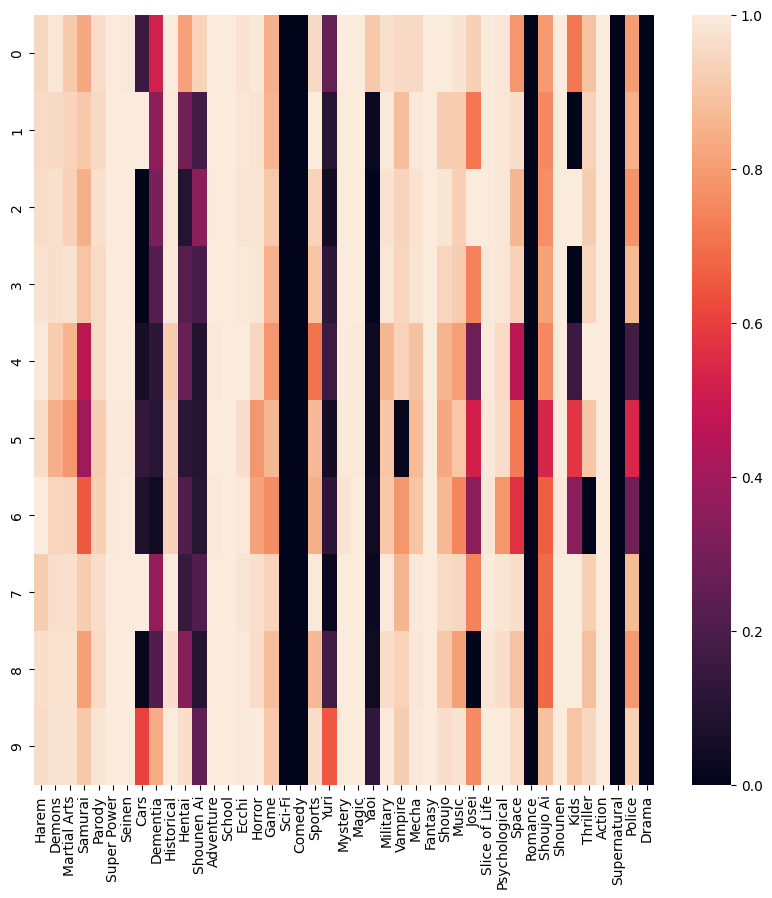

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(pd.DataFrame(kmeans.cluster_centers_, columns=user_genre_ratings.columns))
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

100%|██████████| 29/29 [00:04<00:00,  7.09it/s]


Text(0, 0.5, '$J(C_k)$')

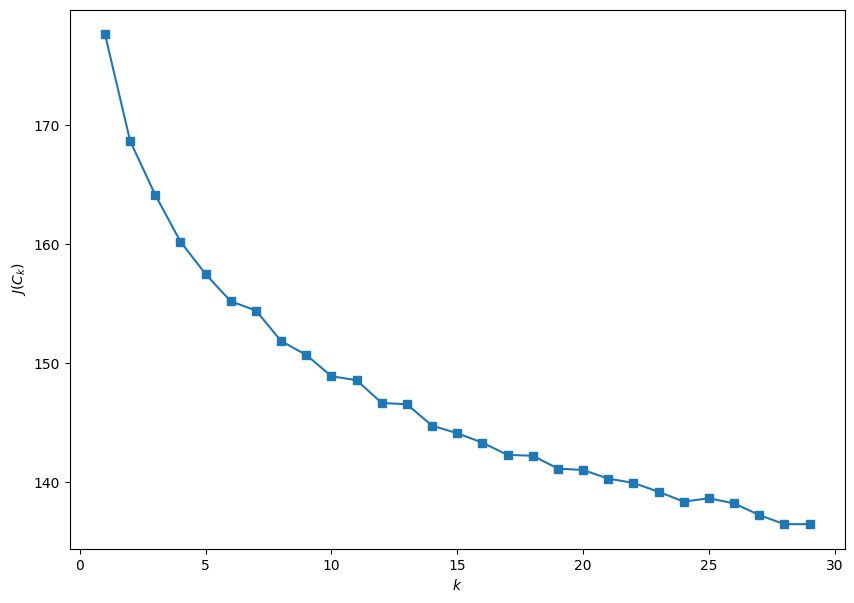

In [78]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [79]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


2

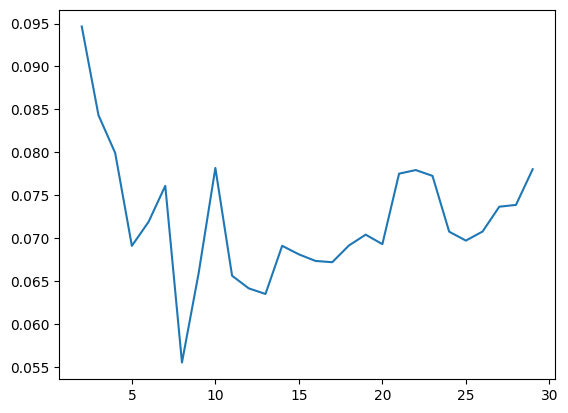

In [80]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

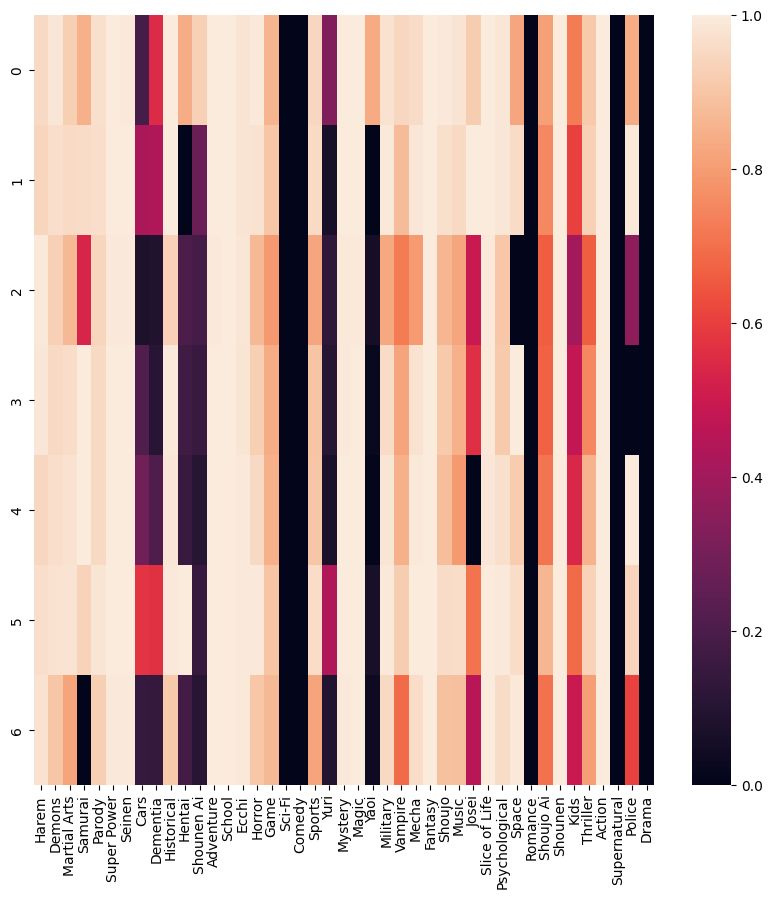

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

k = 7

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(user_genre_ratings_scaled)

plt.figure(figsize=(10, 10))
sns.heatmap(pd.DataFrame(kmeans.cluster_centers_, columns=user_genre_ratings.columns))
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю.
Это можно сделать разными способами. Как это сделать подумайте сами.

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен.
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.




Определение кластера пользователя:
Предположим, у нас есть новый пользователь, для которого необходимо сделать рекомендацию.
Сначала определим кластер, к которому относится этот пользователь, используя обученную модель kMeans.
Для этого нам необходимо создать вектор предпочтений пользователя в формате user_genre_ratings_scaled.
Если у нас нет информации о предпочтениях нового пользователя, можно использовать средние значения для всех жанров.

`new_user_preferences = pd.DataFrame(np.zeros((1, len(user_genre_ratings.columns))), columns=user_genre_ratings.columns)
new_user_cluster = kmeans.predict(scaler.transform(new_user_preferences))`

Анализ кластера и выявление ключевых жанров:
После определения кластера пользователя, выберем наиболее важные жанры для данного кластера.
Для этого можно использовать центры кластеров, полученные после обучения kMeans.
Отсортируем жанры в каждом кластере по значению в центре кластера в порядке убывания

`cluster_center = kmeans.cluster_centers_[new_user_cluster[0]]
sorted_genres = pd.DataFrame(cluster_center, index = user_genre_ratings.columns).sort_values(by=0, ascending=False)`


Поиск аниме:
Из всех аниме в датасете anime выберем те, которые относятся к самым популярным жанрам в кластере пользователя.
Для этого можно использовать таблицу one_hot_genres для проверки принадлежности аниме к определенному жанру.
Допустим, мы выберем топ-3 жанра из отсортированного списка.

`top_genres = sorted_genres.index[:3]
recommended_anime = []`

`for anime_id, row in one_hot_genres.iterrows():
  for genre in top_genres:
    if row[genre] == 1:
      recommended_anime.append(anime_id)
      break`

`recommended_anime = list(set(recommended_anime))`

Ранжирование и рекомендация:
Полученные аниме можно отранжировать по среднему рейтингу в таблице ratings и по количеству просмотров members в таблице anime.
Итоговый список рекомендованных аниме можно вывести пользователю.

`anime_ratings = anime.loc[recommended_anime][['rating','members']]`

`anime_ratings['weighted_rating'] = anime_ratings['rating'] * anime_ratings['members']
final_recommendations = anime_ratings.sort_values(by='weighted_rating', ascending=False)`

`print(final_recommendations.head(10))`


### Extra. Попробуйте как-нибудь улучшить эту рекомендашку. Приведите код или рассуждения на эту тему.

Если писать код, то можно:
 * каждому жанру присвоить свой вес, так как одних жанров сильно много и у них разная смысловая нагрузка. Комедии и экшн встречаются очень часто и врядли кто-то только из-за этих жанров будет смотреть аниме.
 * предсказывать не по жанрам, а по аниме. Там получится очень большая размерность, так как нужно сделать one-hot-encoding по аниме, но может это даст лучше результат(спойлер: нет). (И для этого надо сделать 4 join'а, что, возможно, убьет ваш компьютер или/и мозг)

In [ ]:
#Присвоить весам жанров.
genre_weights = {
    'Action': 0.8, 'Adventure': 0.9, 'Comedy': 0.5,  # примеры весов
    # ... остальные жанры
}

#Вместо среднего значения жанра используйте взвешенное среднее.
for genre in genres:
    if genre in genre_weights:
        df[genre] = df[genre] * genre_weights[genre]
    else:
        df[genre] = df[genre] * 1 # или другой вес для неизвестных жанров